<a href="https://colab.research.google.com/github/pste22/CoinPayments/blob/master/R00195552_deep_q_learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# info about current GPU
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3753501318950839759, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11154422528
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10725280165535478077
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [ ]:
# Ram Info
!cat /proc/meminfo

MemTotal:       13333564 kB
MemFree:         9790836 kB
MemAvailable:   12120300 kB
Buffers:           83092 kB
Cached:          2305636 kB
SwapCached:            0 kB
Active:          1228804 kB
Inactive:        1919264 kB
Active(anon):     641384 kB
Inactive(anon):     2416 kB
Active(file):     587420 kB
Inactive(file):  1916848 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              1508 kB
Writeback:             0 kB
AnonPages:        759340 kB
Mapped:           507236 kB
Shmem:              3064 kB
Slab:             181068 kB
SReclaimable:     131932 kB
SUnreclaim:        49136 kB
KernelStack:        4492 kB
PageTables:         8084 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6666780 kB
Committed_AS:    3545112 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:             1040 kB
AnonHugePages:   

In [ ]:


# Set up for installing the Google Football environment.
!pip install kaggle_environments
!apt-get update -y
!apt-get install -y libsdl2-gfx-dev libsdl2-ttf-dev
!git clone -b v2.3 https://github.com/google-research/football.git
!mkdir -p football/third_party/gfootball_engine/lib
!wget https://storage.googleapis.com/gfootball/prebuilt_gameplayfootball_v2.3.so -O football/third_party/gfootball_engine/lib/prebuilt_gameplayfootball.so
!cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install .

!pip install reinforcement_learning_keras==0.6.0

     |████████████████████████████████| 112kB 5.1MB/s 
     |████████████████████████████████| 61kB 4.0MB/s 
ERROR: nbclient 0.5.3 has requirement jupyter-client>=6.1.5, but you'll have jupyter-client 5.3.5 which is incompatible.
  Found existing installation: jsonschema 2.6.0
    Uninstalling jsonschema-2.6.0:
      Successfully uninstalled jsonschema-2.6.0
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9

In [ ]:
import collections
from typing import Union, Callable, List, Tuple, Iterable, Any
from dataclasses import dataclass

from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import gym
import gfootball
import sys
from statistics import mean

sns.set()

# Tensorflow 2.0 preview release which has eager execution enabled by default. 
# Training keras models in a loop with eager execution on causes memory leaks and terrible performance.
#ref : https://stackoverflow.com/questions/53429896/how-do-i-disable-tensorflows-eager-execution

tf.compat.v1.disable_eager_execution()

sys.path.append("/kaggle/working/kaggle-football/")

# Q-Learning

Q-learners are off-policy temporal difference leaners 

Ref : (https://lilianweng.github.io/lil-log/2018/02/19/a-long-peek-into-reinforcement-learning.html#model-transition-and-reward) 

## Components

 - Agent
   - Model, usually a neural network 
   - Replay buffer (the agent's memory)
   - Exploration method, such as episilon greedy

## Model

Using the GFootball enviroment with the Simple115StateWrapper which returns observations (state) as a (115,) array. 

Simple115StateWrapper is a simplified representation of a game state encoded with 115 floats, which include the numerical coordinates of all the players, ball positions, ball ownership, game modes, etc.

Ref : https://flyyufelix.github.io/2020/12/02/google-football-rl.html

This array will be used as the input to a very simple neural network with 3 layers, which will output an estimated value for every possible action. The agent will either select the action with the highest value as estimated from this model, or randomly (chance depending on epsilon) select a random action.

To make learning more stable with deep-q learners, two copies of this model are used by the agent. 
  - "Action" model This copy is updated every training step and is used to estimate the value of actions for the current state. 
  - "Target" model" The copy is updated by copying the weights of the value model, this is done less frequently in order to keep the training target more stable.

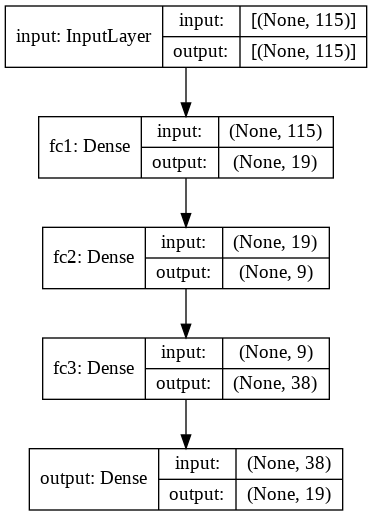

In [ ]:
class DenseNN:
    
    """
    :param observation_shape: Tuple specifying input shape.
    :param n_actions: Int specifying number of outputs
    :param output_activation: Activation function for output. Eg. 
                              None for value estimation (off-policy methods).
    :param unit_scale: Multiplier for all units in FC layers in network 
                       (not used here at the moment).
    :param opt: Keras optimiser to use. Should be string. 
                This is to avoid storing TF/Keras objects here.
    :param learning_rate: Learning rate for optimiser.

    """
    def __init__(self, observation_shape: List[int], n_actions: int, 
                 output_activation: Union[None, str] = None,
                 unit_scale: int = 1, learning_rate: float = 0.0001, 
                 opt: str = 'Adam') -> None:
        self.opt = opt
        self.learning_rate = learning_rate
        self.output_activation = output_activation
        self.unit_scale = unit_scale
        self.n_actions = n_actions
        self.observation_shape = observation_shape
        

    def _model_architecture(self) -> Tuple[keras.layers.Layer, keras.layers.Layer]:
        
        obs_shape = self.observation_shape[0]
        frame_input = keras.layers.Input(name='input', shape=obs_shape)
        fc1 = keras.layers.Dense(int( obs_shape/ 1.5 * self.unit_scale), 
                                 name='fc1', activation='relu')(frame_input)
        fc2 = keras.layers.Dense(int(obs_shape / 3 * self.unit_scale), 
                                 name='fc2', activation='relu')(fc1)
        fc3 = keras.layers.Dense(self.n_actions * 2, 
                                 name='fc3', activation='relu')(fc2)
        action_output = keras.layers.Dense(units=self.n_actions, name='output',
                                           activation=self.output_activation)(fc3)

        return frame_input, action_output
    
    """
    Compile a copy of the model using the provided loss.

    :param model_name: Name of model
    :param loss: Model loss. Default 'mse'. Can be custom callable.
    """

    def compile(self, model_name: str = 'model', 
                loss: Union[str, Callable] = 'mse') -> keras.Model:
        # Get optimiser
        # we can add as many optimizers as we want under elif
        if self.opt.lower() == 'adam':
            opt = keras.optimizers.Adam
        else:
            raise ValueError(f"Invalid optimiser {self.opt}")

        state_input, action_output = self._model_architecture()
        model = keras.Model(inputs=[state_input], outputs=[action_output], 
                            name=model_name)
        model.compile(optimizer=opt(learning_rate=self.learning_rate), 
                      loss=loss)

        return model
    
    def plot(self, model_name: str = 'model') -> None:
        keras.utils.plot_model(self.compile(model_name), 
                               to_file=f"{model_name}.png", show_shapes=True)
        plt.show()


DenseNN(observation_shape=(115,), unit_scale=0.25, n_actions=19).plot()
Image(filename='model.png')

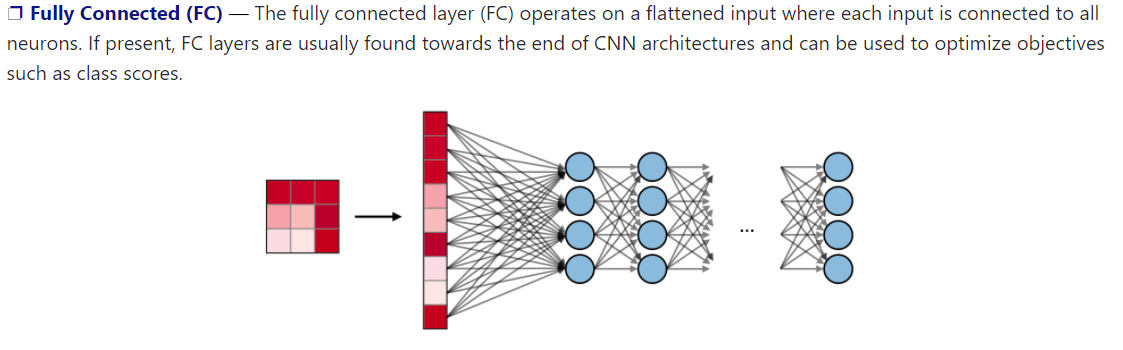![image.png](attachment:image.png)

Ref : https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks#:~:text=Fully%20Connected%20(FC)%20The%20fully,objectives%20such%20as%20class%20scores.

Replay Buffer : records previous state,action and rewards. A training set is created when the agent is updated and a sample of batch is created from the replay buffer. These samples can come from different episodes if the buffer is long enough. 
This is very important in order to reduce the high correlation between training data. Neural network dont do well is training data is highly correlated.

Ref : https://livebook.manning.com/concept/reinforcement-learning/experience-replay

In [ ]:
#ref : https://docs.python.org/3/library/dataclasses.html
@dataclass
class ReplayBuffer:
    
    '''
    considering a buffer size of 50
    '''
    buffer_size: int = 50

    def __post_init__(self) -> None:
        
        #deque : Returns a new deque object initialized left-to-right (using append()) with data from iterable. 
        #Deques are a generalization of stacks and queues (the name is pronounced “deck” and is short for “double-ended queue”). 
        #Deques support thread-safe, memory efficient appends and pops from either side of the deque with approximately the same O(1) performance in either direction.
        #ref : https://docs.python.org/3/library/collections.html#collections.deque
        
        self._state_queue = collections.deque(maxlen=self.buffer_size)
        self._other_queue = collections.deque(maxlen=self.buffer_size)

        self.queue = collections.deque(maxlen=self.buffer_size)

    
    def __len__(self) -> int:
        return self.n if (self.n > 0) else 0

    """
    flag to check whether the buffer is full
    """
    @property
    def full(self) -> bool:
        return len(self._state_queue) == self.buffer_size
    
    """
    returns length of state_queue
    """
    @property
    def n(self) -> int:
        return len(self._state_queue) - 1

    """
    :param items: Tuple containing (s, a, r, d).
    state queue contains state (s)
    other queue contain action,reward and discount (a,r,d)
    """
    def append(self, items: Tuple[Any, int, float, bool]) -> None:
        
        self._state_queue.append(items[0])
        self._other_queue.append(items[1::])
    
    """
    returns a batch containing state, action, reward and discount and next state
    """
    def get_batch(self, idxs: Iterable[int]) -> Tuple[List[np.ndarray], 
                                                      List[np.ndarray],
                                                      List[float], 
                                                      List[bool], 
                                                      List[np.ndarray]]:
        ss = [self._state_queue[i] for i in idxs]
        ss_ = [self._state_queue[i + 1] for i in idxs]

        ard = [self._other_queue[i] for i in idxs]
        aa = [a for (a, _, _) in ard]
        rr = [r for (_, r, _) in ard]
        dd = [d for (_, _, d) in ard]

        return ss, aa, rr, dd, ss_
    
    
    """
    randomizes the batch
    """
    def sample_batch(self, n: int) -> Tuple[List[np.ndarray], 
                                            List[np.ndarray],
                                            List[float], 
                                            List[bool], 
                                            List[np.ndarray]]:
        if n > self.n:
            raise ValueError

        idxs = np.random.randint(0, self.n, n)
        return self.get_batch(idxs)

Epsilon Greedy

Epsilon greedy enables the agent to explore the environment. 
Before an agent makes an action, it considers a random value between 0 and 1. if this value > epsilon , the agent take random action. 
Eplison is generally set at a high value initially at the beginning of the traning and it slowly decays over time. Hence Eplison is decay factor. 

In [ ]:
@dataclass
class EpsilonGreedy:
    """
    Handles epsilon-greedy action selection, decay of epsilon during training.

    :param eps_initial: Initial epsilon value.
    :param decay: Decay rate in percent (should be positive to decay).
    :param decay_schedule: 'linear' or 'compound'.
    :param eps_min: The min value epsilon can fall to.
    :param state: Random state, used to pick between the greedy or random options.
    """
    eps_initial: float = 0.2
    decay: float = 0.0001
    decay_schedule: str = 'compound'
    eps_min: float = 0.01
    state = None
    
    def __post_init__(self) -> None:
        self._step: int = 0
        self.eps_current = self.eps_initial

        valid_decay = ('linear', 'compound')
        if self.decay_schedule.lower() not in valid_decay:
            raise ValueError(f"Invalid decay schedule {self.decay_schedule}. "
                             "Pick from {valid_decay}.")

        self._set_random_state()

    def _set_random_state(self) -> None:
        self._state = np.random.RandomState(self.state)

    def _linear_decay(self) -> float:
        return self.eps_current - self.decay

    def _compound_decay(self) -> float:
        return self.eps_current - self.eps_current * self.decay

    """
    returns max between eps_min and new_eps value which is new epsilon value post calculation(compound or linear)
    in case new_eps value falls below eps_min set at the start, eps_min will be returned
    """
    def _decay(self):
        new_eps = np.nan
        if self.decay_schedule.lower() == 'linear':
            new_eps = self._linear_decay()

        if self.decay_schedule.lower() == 'compound':
            new_eps = self._compound_decay()

        self._step += 1

        return max(self.eps_min, new_eps)
    
    """
    Apply epsilon greedy selection.

    If training, decay epsilon, and return selected option. 
    If not training, just return greedy_option.

    Use of lambdas is to avoid unnecessarily picking between 
    two pre-computed options.

    :param greedy_option: Function to evaluate if random option 
                          is NOT picked.
    :param random_option: Function to evaluate if random option 
                          IS picked.
    :param training: Bool indicating if call is during training 
                     and to use epsilon greedy and decay.
    :return: Evaluated selected option.
    """

    def select(self, greedy_option: Callable, random_option: Callable,
               training: bool = False) -> Any:
        if training:
            self.eps_current = self._decay()
            if self._state.random() < self.eps_current:
                return random_option()

        return greedy_option()

In [ ]:
@dataclass
class DQNAgent:
    replay_buffer: ReplayBuffer
    eps: EpsilonGreedy
    model_architecture: DenseNN
    name: str = 'DQNAgent'
    double: bool = False
    noisy: bool = False
    gamma: float = 0.99
    replay_buffer_samples: int = 75
    final_reward: Union[float, None] = None

    def __post_init__(self) -> None:
        self._build_model()

    """
    Prepare two of the same model.

    The action model is used to pick actions and the target model
    is used to predict value of Q(s', a). Action model
    weights are updated on every buffer sample + training step. 
    The target model is never directly trained, but it's
    weights are updated to match the action model at the end of 
    each episode.
    """

    def _build_model(self) -> None:
        self._action_model = self.model_architecture.compile(
            model_name='action_model', loss='mse')
        self._target_model = self.model_architecture.compile(
            model_name='target_model', loss='mse')

    def transform(self, s: np.ndarray) -> np.ndarray:
        """Check input shape, add Row dimension if required."""

        if len(s.shape) < len(self._action_model.input.shape):
            s = np.expand_dims(s, 0)

        return s

    """
    First the most recent step is added to the buffer.

    s' isn't saved because there's no need. it will added in next step
    """
    def update_experience(self, s: np.ndarray, a: int, 
                          r: float, d: bool) -> None:
        

        # Add s, a, r, d to replay buffer
        self.replay_buffer.append((s, a, r, d))

    """
    Sample a batch from the replay buffer, calculate targets using 
    target model, and train action model.

    If the buffer is below its minimum size, no training is done.

    If the buffer has reached its minimum size, a training batch 
    from the replay buffer and the action model is updated.

    This update samples random (s, a, r, s') sets from the buffer 
    and calculates the discounted reward for each set.
    The value of the actions at states s and s' are predicted from 
    the value model. The action model is updated using these value 
    predictions as the targets. The value of performed action is 
    updated with the discounted reward (using its value prediction 
    at s'). ie. x=s, y=[action value 1, action value 2].
    """

    def update_model(self) -> None:
    
        # If buffer isn't full, don't train
        #print("self.replay_buffer.full=>",self.replay_buffer.full)
        if not self.replay_buffer.full:
            return

        # Else sample batch from buffer
        ss, aa, rr, dd, ss_ = self.replay_buffer.sample_batch(
            self.replay_buffer_samples)
        
        
        #print(f"ss=>",ss)
        #print(f"aa=>",aa)
        #print(f"rr=>",rr)
        #print(f"dd=>",dd)
        #print(f"ss_",ss)

        # Calculate estimated S,A values for current states and next states. 
        ss = np.array(ss)
        ss_ = np.array(ss_)
        
        y_now = self._target_model.predict_on_batch(np.vstack(ss))
        y_future = self._target_model.predict_on_batch(np.vstack(ss_))
        
        
        # Update rewards where not done with y_future predictions
        #print("\ndd=>\n",dd)
        #print("dd shape",dd.shape)
        # dd_mask is an array of bools indicating whether the episode was completed on that step 
        # (this is for all the replay buffer samples, not just the current episode). 
        # It's used to index into the array rewards and set the final reward where it is the final step.
        dd_mask = np.array(dd, dtype=bool).squeeze()
        #print("\ndd_mask=>\n",dd_mask)
        #print("dd_mask shape",dd_mask.shape)
        rr = np.array(rr, dtype=float).squeeze()

        # Gather max action indexes and update relevant actions in y
        if self.double:
          # If using double dqn select best actions using the action model, 
          # but the value of those action using the
          # target model (already have in y_future). 
          y_future_action_model = self._action_model.predict_on_batch(ss_)
          selected_actions = np.argmax(y_future_action_model[~dd_mask, :], 
                                        axis=1)
        else:
          selected_actions = np.argmax(y_future[~dd_mask, :], 
                                         axis=1)
        
        #print("\nselected_actions=>\n",selected_actions)

        # Update reward values with estimated values (where not done) 
        # and final rewards (where done)
        rr[~dd_mask] += y_future[~dd_mask, selected_actions]
        #print("\nrr post dd_mask=>\n",rr)
        
        if self.final_reward is not None:
            # If self.final_reward is set, set done cases to this value. 
            # Else leave as observed reward.
            rr[dd_mask] = self.final_reward
        
        aa = np.array(aa, dtype=int)
        
        #print("y_now before put along axis",y_now)
        #print("y_now shape before put along axis",y_now.shape)
        
        #print("aa shape",aa.shape)
        #print("aa reshape",aa.reshape(-1,1))
        #print("rr reshape",rr.shape)
        #print("rr reshape",rr.reshape(-1, 1))
        
        # np.put_along_axis puts the values in rr which holds the rewards for the sampled steps, 
        # into the relevant indexes (in aa, which are the actions) of the y_now array.
        np.put_along_axis(y_now, aa.reshape(-1, 1), rr.reshape(-1, 1), axis=1)
        #print("y_now after put along axis",y_now)
        #print("y_now shape after put along axis",y_now.shape)
        

        # Fit model with updated y_now values
        # Runs a single gradient update on a single batch of data.
        # Train_on_batch will also see a performance increase over fit and fit generator for
        # using large datasets and don't have easily serializable data (like high rank numpy arrays), to write to tfrecords.
        # Ref : https://stackoverflow.com/questions/49100556/what-is-the-use-of-train-on-batch-in-keras
        self._action_model.train_on_batch(ss, y_now)

    """
    Get best action(s) from model - the one with the highest predicted value.

    :param s: A single or multiple rows of state observations.
    :return: The selected action.
    """

    def get_best_action(self, s: np.ndarray) -> np.ndarray:
        preds = self._action_model.predict(self.transform(s))

        return np.argmax(preds)

    """
    Get an action using get_best_action or epsilon greedy.

    Epsilon decays every time a random action is chosen.

    :param s: The raw state observation.
    :param training: Bool to indicate whether or not to use this 
                     experience to update the model. If False, just
                     returns best action.
    :return: The selected action.
    """
    def get_action(self, s: np.ndarray, training: bool = False) -> int:
        
        action = self.eps.select(greedy_option=lambda: self.get_best_action(s),
                                 random_option=lambda: self.env.action_space.sample(),
                                 training=training)

        return action

    """
    Update the value model with the weights of the action model 
    (which is updated each step).

    The value model is updated less often to maintain stability.
    """

    def update_target_model(self) -> None:
        self._target_model.set_weights(self._action_model.get_weights())

    """Value model synced with action model at the end of each episode."""
    
    def after_episode_update(self) -> None:
        self.update_target_model()

    """
    Use this to define the discounted reward for unfinished episodes, 
    default is 1 step TD.
    """  
    def _discounted_reward(self, reward: float, 
                           estimated_future_action_rewards: np.ndarray) -> float:
        return reward + self.gamma * np.max(estimated_future_action_rewards)

    """
    Calculate discounted reward for a single step.

    :param reward: Last real reward.
    :param estimated_future_action_rewards: Estimated future values 
                                            of actions taken on next step.
    :param done: Flag indicating if this is the last step on an episode.
    :return: Reward.
    """

    def _get_reward(self, reward: float, 
                    estimated_future_action_rewards: np.ndarray, 
                    done: bool) -> float:
    
        if done:
            # If done, reward is just this step. Can finish because agent has won or lost.
            return self._final_reward(reward)
        else:
            # Otherwise, it's the reward plus the predicted max value of next action
            return self._discounted_reward(reward, 
                                           estimated_future_action_rewards) 

Play Single Episode

In [ ]:
"""
env :the gym environment
agent : the DQN Agent
n_steps : total number of steps the model should be run for
pr : a boolean flag that decides whether to print 
training : a boolean flag that decides whether training is true/false

returns a tuple of episode_rewards,episode_actions
"""


def play_single_episode(env: gym.Env, agent, n_steps: int=10, pr: bool=False, 
                 training:bool=False) -> Tuple[List[float], List[int]]:
        
    episode_rewards = []
    episode_actions = []
    
    #reset the environment
    obs = env.reset()
    done = False
    
    #iterate for n_steps
    for s in range(n_steps):
        if done:
            break

        # Select action
        action = agent.get_action(obs)
        episode_actions.append(action)

        # Take action
        prev_obs = obs
        
        #on taking an action, env returns 
            #observation, 
            #reward taken by the action, 
            #whether done is true or false, 
            #info about the action(scoring reward)
        obs, reward, done, info = env.step(action)
        episode_rewards.append(reward)

        # Update model
        if training:
            agent.update_experience(s=prev_obs, a=action, 
                                    r=reward, d=done)
            agent.update_model()

        if pr:
            print(f"Step {s}: Action taken {action}, "f"reward recieved {reward}")

        last_step = s
    
    if training:
        agent.after_episode_update()
                  
    return episode_rewards, episode_actions
                  

env = gym.make("GFootball-11_vs_11_kaggle-simple115v2-v0")
#print("env.action_space.n-=>\n",env.action_space.n)
agent = DQNAgent(
    replay_buffer=ReplayBuffer(buffer_size=1000),  
    eps=EpsilonGreedy(),
    model_architecture=DenseNN(observation_shape=env.observation_space.shape, 
                               # Setting low value to make it easier to run in notebook
                               unit_scale=0.25,
                               n_actions=env.action_space.n))

_ = play_single_episode(env, agent, n_steps=20, pr=True, training=True)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Step 0: Action taken 4, reward recieved 0.0
Step 1: Action taken 17, reward recieved 0.0
Step 2: Action taken 17, reward recieved 0.0
Step 3: Action taken 17, reward recieved 0.0
Step 4: Action taken 17, reward recieved 0.0
Step 5: Action taken 4, reward recieved 0.0
Step 6: Action taken 4, reward recieved 0.0
Step 7: Action taken 9, reward recieved 0.0
Step 8: Action taken 17, reward recieved 0.0
Step 9: Action taken 17, reward recieved 0.0
Step 10: Action taken 17, reward recieved 0.0
Step 11: Action taken 17, reward recieved 0.0
Step 12: Action taken 17, reward recieved 0.0
Step 13: Action taken 17, reward recieved 0.0
Step 14: Action taken 17, reward recieved 0.0
Step 15: Action taken 9, reward recieved 0.0
Step 16: Action taken 9, reward recieved 0.0
Step 17: Action taken 9, reward recieved 0.0
Step 18: Action taken 9, reward recieved 0.0
Step 19: Action taken 9, reward recieved 0.0


In [ ]:
def run_multiple_episodes(env: gym.Env, agent, n_episodes: int=10, 
                          n_steps: int=10, pr: bool=False, 
                          training:bool=False) -> List[float]:

    
    total_episode_rewards = []
    for ep in range(n_episodes):

        episode_rewards, _ = play_single_episode(env, agent, n_steps, 
                                          pr=False, training=True)

        total_episode_rewards.append(sum(episode_rewards))
        
        if pr:
            print(f"Episode {ep} finished after {len(episode_rewards)} "
                  f"steps, total reward: {sum(episode_rewards)}")

    
    return total_episode_rewards


env = gym.make("GFootball-11_vs_11_kaggle-simple115v2-v0")
baseDQNagent = DQNAgent(
    replay_buffer=ReplayBuffer(buffer_size=1000),
    eps=EpsilonGreedy(eps_initial=0.7),
    model_architecture=DenseNN(observation_shape=env.observation_space.shape, 
                               unit_scale=0.25,
                               n_actions=env.action_space.n))

doubleDQNagent = DQNAgent(
    replay_buffer=ReplayBuffer(buffer_size=1000),
    eps=EpsilonGreedy(eps_initial=0.7),
    model_architecture=DenseNN(observation_shape=env.observation_space.shape, 
                               unit_scale=0.25,
                               n_actions=env.action_space.n),
    double = True)

'''
nmber_of_episodes = 10
# Both n_episodes and n_steps need to 

dqn_reward_history = run_multiple_episodes(env, baseDQNagent, n_episodes=10, 
                                       # Use 3000 for 90 minute games
                                       n_steps=3000,  
                                       training=True, pr=True)

print("\n-------------------------------------------------------------")
print("\nThe mean of reward history over the {} episodes : {}".format(nmber_of_episodes, mean(reward_history_baseDQN) ))
print("\n-------------------------------------------------------------")

plt.plot(reward_history_baseDQN)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()
'''


'\nnmber_of_episodes = 10\n# Both n_episodes and n_steps need to \n\ndqn_reward_history = run_multiple_episodes(env, baseDQNagent, n_episodes=10, \n                                       # Use 3000 for 90 minute games\n                                       n_steps=3000,  \n                                       training=True, pr=True)\n\nprint("\n-------------------------------------------------------------")\nprint("\nThe mean of reward history over the {} episodes : {}".format(nmber_of_episodes, mean(reward_history_baseDQN) ))\nprint("\n-------------------------------------------------------------")\n\nplt.plot(reward_history_baseDQN)\nplt.xlabel(\'Episode\')\nplt.ylabel(\'Reward\')\nplt.show()\n'

In [ ]:
class RandomModel:
    def __init__(self, n_actions: int):
        self.n_actions = n_actions

    def predict(self) -> int:
        return int(np.random.randint(0, self.n_actions, 1))


@dataclass
class RandomAgent:
    """A random agent that acts randomly and learns nothing."""
    n_actions: int
    name: str = 'RandomAgent'

    def __post_init__(self) -> None:
        self._build_model()

    def _build_model(self) -> None:
        """Set model function."""
        self.model = RandomModel(self.n_actions)

    def update_model(self, *args, **kwargs) -> None:
        """No model to update."""
        pass

    def update_experience(self, s: np.ndarray, a: int, 
                          r: float, d: bool) -> None:
        """nothing to update"""
        pass

    def get_action(self, s: Any, **kwargs) -> int:
        return self.model.predict()

    def after_episode_update(self) -> None:
      pass

In [ ]:
# for 10 episodes
'''
env = gym.make("GFootball-11_vs_11_kaggle-simple115v2-v0")
obs = env.reset()

number_of_episodes = 10

random_agent = RandomAgent(n_actions=env.action_space.n)


ra_reward_history = run_multiple_episodes(env, random_agent, n_episodes=number_of_episodes, 
                                          n_steps=3000, training=True, pr=True)


dqn_reward_history = run_multiple_episodes(env, baseDQNagent, n_episodes=number_of_episodes, 
                                           n_steps=3000, training=True, pr=True)

double_dqn_reward_history = run_multiple_episodes(env, doubleDQNagent, n_episodes=number_of_episodes, 
                                           n_steps=3000, training=True, pr=True)


plt.plot(ra_reward_history, label='Random')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(title='Random Agent for 10 Episodes')
plt.show()

print("\n------------------------------------------------------------\n")
print("Mean of rewards for {} : Eipsodes : {} for RandomAgent ".format(number_of_episodes, mean(ra_reward_history) ))
print("\n------------------------------------------------------------\n")
'''

'\nenv = gym.make("GFootball-11_vs_11_kaggle-simple115v2-v0")\nobs = env.reset()\n\nnumber_of_episodes = 10\n\nrandom_agent = RandomAgent(n_actions=env.action_space.n)\n\n\nra_reward_history = run_multiple_episodes(env, random_agent, n_episodes=number_of_episodes, \n                                          n_steps=3000, training=True, pr=True)\n\n\ndqn_reward_history = run_multiple_episodes(env, baseDQNagent, n_episodes=number_of_episodes, \n                                           n_steps=3000, training=True, pr=True)\n\ndouble_dqn_reward_history = run_multiple_episodes(env, doubleDQNagent, n_episodes=number_of_episodes, \n                                           n_steps=3000, training=True, pr=True)\n\n\nplt.plot(ra_reward_history, label=\'Random\')\nplt.xlabel(\'Episode\')\nplt.ylabel(\'Reward\')\nplt.legend(title=\'Random Agent for 10 Episodes\')\nplt.show()\n\nprint("\n------------------------------------------------------------\n")\nprint("Mean of rewards for {} : Eipsodes :

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Episode 0 finished after 3000 steps, total reward: -9.0
Episode 1 finished after 3000 steps, total reward: -3.0
Episode 2 finished after 3000 steps, total reward: -3.0
Episode 3 finished after 3000 steps, total reward: -4.0
Episode 4 finished after 3000 steps, total reward: -2.0
Episode 5 finished after 3000 steps, total reward: -1.0
Episode 6 finished after 3000 steps, total reward: -4.0
Episode 7 finished after 3000 steps, total reward: -3.0
Episode 8 finished after 3000 steps, total reward: -8.0
Episode 9 finished after 3000 steps, total reward: -3.0
Episode 0 finished after 3000 steps, total reward: -1.0
Episode 1 finished after 3000 steps, total reward: 0.0
Episode 2 finished after 3000 steps, total reward: 0.0
Episode 3 finished after 3000 steps, total reward: 0.0
Episode 4 finished after 3000 steps, total reward: 0.0
Episode 5 finished after 3000 steps, total reward: 0.0
Episode 6 finished after 3000 steps, total reward: 0.0
Episode 7 finished after 3000 steps, total reward: 0.0

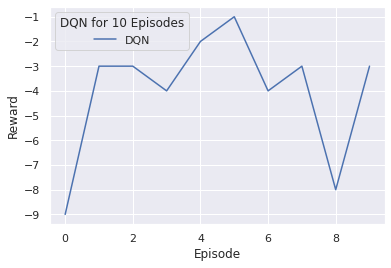

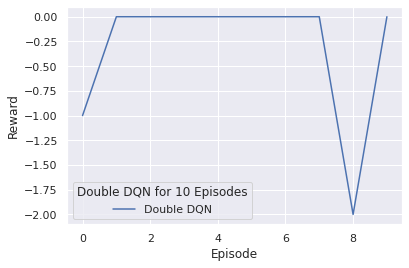

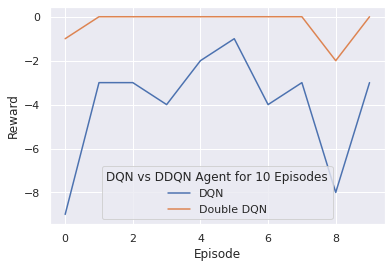


------------------------------------------------------------

Mean of rewards for 10 Episodes : -4.0 for Base DQN
Mean of rewards for 10 Episodes : -0.3 for Double DQN

------------------------------------------------------------



In [ ]:
# for 10 episodes

env = gym.make("GFootball-11_vs_11_kaggle-simple115v2-v0")
obs = env.reset()

number_of_episodes = 10

dqn_reward_history = run_multiple_episodes(env, doubleDQNagent, n_episodes=number_of_episodes, 
                                           n_steps=3000, training=True, pr=True)

double_dqn_reward_history = run_multiple_episodes(env, baseDQNagent, n_episodes=number_of_episodes, 
                                           n_steps=3000, training=True, pr=True)



plt.plot(dqn_reward_history, label='DQN')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(title='DQN for 10 Episodes')
plt.show()

plt.plot(double_dqn_reward_history, label='Double DQN')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(title='Double DQN for 10 Episodes')
plt.show()


plt.plot(dqn_reward_history, label='DQN')
plt.plot(double_dqn_reward_history, label='Double DQN')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(title='DQN vs DDQN Agent for 10 Episodes')
plt.show()

print("\n------------------------------------------------------------\n")
print("Mean of rewards for {} Episodes : {} for Base DQN".format(number_of_episodes, mean(dqn_reward_history) ))
print("Mean of rewards for {} Episodes : {} for Double DQN".format(number_of_episodes, mean(double_dqn_reward_history) ))
print("\n------------------------------------------------------------\n")

Episode 0 finished after 3000 steps, total reward: -2.0
Episode 1 finished after 3000 steps, total reward: -1.0
Episode 2 finished after 3000 steps, total reward: -2.0
Episode 3 finished after 3000 steps, total reward: -3.0
Episode 4 finished after 3000 steps, total reward: -2.0
Episode 5 finished after 3000 steps, total reward: -6.0
Episode 6 finished after 3000 steps, total reward: -4.0
Episode 7 finished after 3000 steps, total reward: -1.0
Episode 8 finished after 3000 steps, total reward: -4.0
Episode 9 finished after 3000 steps, total reward: -2.0
Episode 10 finished after 3000 steps, total reward: -7.0
Episode 11 finished after 3000 steps, total reward: -5.0
Episode 12 finished after 3000 steps, total reward: -2.0
Episode 13 finished after 3000 steps, total reward: -4.0
Episode 14 finished after 3000 steps, total reward: -3.0
Episode 15 finished after 3000 steps, total reward: -2.0
Episode 16 finished after 3000 steps, total reward: -1.0
Episode 17 finished after 3000 steps, tot

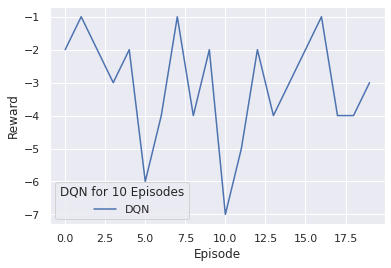

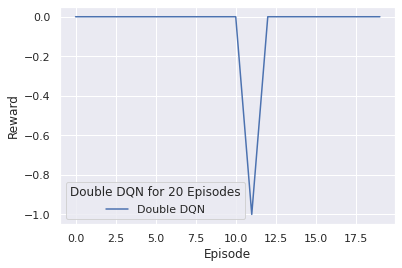

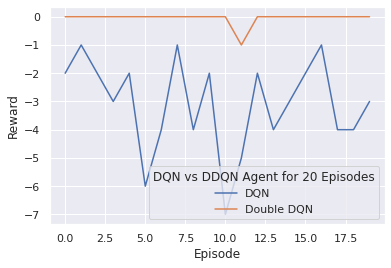


------------------------------------------------------------

Mean of rewards for 20 Episodes : -3.1 for Base DQN
Mean of rewards for 20 Episodes : -0.05 for Double DQN

------------------------------------------------------------



In [ ]:
# for 20 episodes

env = gym.make("GFootball-11_vs_11_kaggle-simple115v2-v0")
obs = env.reset()

number_of_episodes = 20

dqn_reward_history = run_multiple_episodes(env, doubleDQNagent, n_episodes=number_of_episodes, 
                                           n_steps=3000, training=True, pr=True)

double_dqn_reward_history = run_multiple_episodes(env, baseDQNagent, n_episodes=number_of_episodes, 
                                           n_steps=3000, training=True, pr=True)



plt.plot(dqn_reward_history, label='DQN')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(title='DQN for 10 Episodes')
plt.show()

plt.plot(double_dqn_reward_history, label='Double DQN')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(title='Double DQN for 20 Episodes')
plt.show()


plt.plot(dqn_reward_history, label='DQN')
plt.plot(double_dqn_reward_history, label='Double DQN')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(title='DQN vs DDQN Agent for 20 Episodes')
plt.show()

print("\n------------------------------------------------------------\n")
print("Mean of rewards for {} Episodes : {} for Base DQN".format(number_of_episodes, mean(dqn_reward_history) ))
print("Mean of rewards for {} Episodes : {} for Double DQN".format(number_of_episodes, mean(double_dqn_reward_history) ))
print("\n------------------------------------------------------------\n")

In [ ]:
import zlib

import pickle
weights_bytes = zlib.compress(pickle.dumps(baseDQNagent._action_model.get_weights()))

In [ ]:
import zlib
import pickle
import tensorflow as tf

import numpy as np

from tensorflow import keras
from typing import List, Tuple, Union, Callable
from gfootball.env.wrappers import Simple115StateWrapper

class DenseNN:

    def __init__(self, observation_shape: List[int], n_actions: int, 
                 output_activation: Union[None, str] = None,
                 unit_scale: int = 1, learning_rate: float = 0.0001, 
                 opt: str = 'Adam') -> None:
        """
        :param observation_shape: Tuple specifying input shape.
        :param n_actions: Int specifying number of outputs
        :param output_activation: Activation function for output.
        :param unit_scale: Multiplier for all units in FC layers in network 
                           (not used here at the moment).
        :param opt: Keras optimiser to use. Should be string. 
                    This is to avoid storing TF/Keras objects here.
        :param learning_rate: Learning rate for optimiser.

        """
        self.observation_shape = observation_shape
        self.n_actions = n_actions
        self.unit_scale = unit_scale
        self.output_activation = output_activation
        self.learning_rate = learning_rate
        self.opt = opt

    def _model_architecture(self) -> Tuple[keras.layers.Layer, keras.layers.Layer]:
        
        frame_input = keras.layers.Input(name='input', shape=self.observation_shape)
        fc1 = keras.layers.Dense(int(self.observation_shape[0] / 1.5 * self.unit_scale), 
                                 name='fc1', activation='relu')(frame_input)
        fc2 = keras.layers.Dense(int(self.observation_shape[0] / 3 * self.unit_scale), 
                                 name='fc2', activation='relu')(fc1)
        fc3 = keras.layers.Dense(self.n_actions * 2, 
                                 name='fc3', activation='relu')(fc2)
        action_output = keras.layers.Dense(units=self.n_actions, name='output',
                                           activation=self.output_activation)(fc3)

        return frame_input, action_output

    def compile(self, model_name: str = 'model', 
                loss: Union[str, Callable] = 'mse') -> keras.Model:
        """
        Compile a copy of the model using the provided loss.

        :param model_name: Name of model
        :param loss: Model loss. Default 'mse'. Can be custom callable.
        """
        # Get optimiser
        if self.opt.lower() == 'adam':
            opt = keras.optimizers.Adam
        elif self.opt.lower() == 'rmsprop':
            opt = keras.optimizers.RMSprop
        else:
            raise ValueError(f"Invalid optimiser {self.opt}")

        state_input, action_output = self._model_architecture()
        model = keras.Model(inputs=[state_input], outputs=[action_output], 
                            name=model_name)
        model.compile(optimizer=opt(learning_rate=self.learning_rate), 
                      loss=loss)

        return model

    def plot(self, model_name: str = 'model') -> None:
        keras.utils.plot_model(self.compile(model_name), 
                               to_file=f"{model_name}.png", show_shapes=True)
        plt.show()

tf_mod = DenseNN(observation_shape=(115,), 
                 # This needs to match the number from training
                 unit_scale=0.25,
                 n_actions=19).compile()
tf_mod.set_weights(pickle.loads(zlib.decompress(weights_bytes)))

def agent(obs):

    # Use the existing model and obs buffer on each call to agent
    global tf_mod

    # Convert these to the same output as the Simple115StateWrapper we used in training
    obs = Simple115StateWrapper.convert_observation(obs['players_raw'], fixed_positions=False)

    # Predict actions from keras model
    actions = tf_mod.predict(obs)
    action = np.argmax(actions)

    return [action]

In [ ]:
"""
env :the gym environment
agent : the DQN Agent
n_steps : total number of steps the model should be run for
pr : a boolean flag that decides whether to print 
training : a boolean flag that decides whether training is true/false

returns a tuple of episode_rewards,episode_actions
"""


def play_single_episode(env: gym.Env, agent, n_steps: int=10, pr: bool=False, 
                 training:bool=False) -> Tuple[List[float], List[int]]:
        
    episode_rewards = []
    episode_actions = []
    
    #reset the environment
    obs = env.reset()
    done = False
    
    #iterate for n_steps
    for s in range(n_steps):
        if done:
            break

        # Select action
        action = agent.get_action(obs)
        episode_actions.append(action)

        # Take action
        prev_obs = obs
        
        #on taking an action, env returns 
            #observation, 
            #reward taken by the action, 
            #whether done is true or false, 
            #info about the action(scoring reward)
        obs, reward, done, info = env.step(action)
        episode_rewards.append(reward)

        # Update model
        if training:
            agent.update_experience(s=prev_obs, a=action, 
                                    r=reward, d=done)
            agent.update_model()

        if pr:
            print(f"Step {s}: Action taken {action}, "f"reward recieved {reward}")

        last_step = s
    
    if training:
        agent.after_episode_update()
                  
    return episode_rewards, episode_actions
                  

env = gym.make("GFootball-11_vs_11_kaggle-simple115v2-v0")
#print("env.action_space.n-=>\n",env.action_space.n)
agent = DQNAgent(
    replay_buffer=ReplayBuffer(buffer_size=1000),  
    eps=EpsilonGreedy(),
    model_architecture=DenseNN(observation_shape=env.observation_space.shape, 
                               # Setting low value to make it easier to run in notebook
                               unit_scale=0.25,
                               n_actions=env.action_space.n))

_ = play_single_episode(env, agent, n_steps=20, pr=True, training=True)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Step 0: Action taken 6, reward recieved 0.0
Step 1: Action taken 3, reward recieved 0.0
Step 2: Action taken 3, reward recieved 0.0
Step 3: Action taken 3, reward recieved 0.0
Step 4: Action taken 3, reward recieved 0.0
Step 5: Action taken 4, reward recieved 0.0
Step 6: Action taken 4, reward recieved 0.0
Step 7: Action taken 4, reward recieved 0.0
Step 8: Action taken 5, reward recieved 0.0
Step 9: Action taken 5, reward recieved 0.0
Step 10: Action taken 5, reward recieved 0.0
Step 11: Action taken 5, reward recieved 0.0
Step 12: Action taken 5, reward recieved 0.0
Step 13: Action taken 5, reward recieved 0.0
Step 14: Action taken 5, reward recieved 0.0
Step 15: Action taken 5, reward recieved 0.0
Step 16: Action taken 5, reward recieved 0.0
Step 17: Action taken 5, reward recieved 0.0
Step 18: Action taken 5, reward recieved 0.0
Step 19: Action taken 4, reward recieved 0.0


In [ ]:
def run_multiple_episodes(env: gym.Env, agent, n_episodes: int=10, 
                          n_steps: int=10, pr: bool=False, 
                          training:bool=False) -> List[float]:

    
    total_episode_rewards = []
    for ep in range(n_episodes):

        episode_rewards, _ = play_single_episode(env, agent, n_steps, 
                                          pr=False, training=True)

        total_episode_rewards.append(sum(episode_rewards))
        
        if pr:
            print(f"Episode {ep} finished after {len(episode_rewards)} "
                  f"steps, total reward: {sum(episode_rewards)}")

    
    return total_episode_rewards


env = gym.make("GFootball-11_vs_11_kaggle-simple115v2-v0")
baseDQNagent = DQNAgent(
    replay_buffer=ReplayBuffer(buffer_size=1000),
    eps=EpsilonGreedy(eps_initial=0.7),
    model_architecture=DenseNN(observation_shape=env.observation_space.shape, 
                               unit_scale=0.25,
                               n_actions=env.action_space.n))

doubleDQNagent = DQNAgent(
    replay_buffer=ReplayBuffer(buffer_size=1000),
    eps=EpsilonGreedy(eps_initial=0.7),
    model_architecture=DenseNN(observation_shape=env.observation_space.shape, 
                               unit_scale=0.25,
                               n_actions=env.action_space.n),
    double = True)

# Both n_episodes and n_steps need to 
'''
reward_history = run_multiple_episodes(env, agent, n_episodes=10, 
                                       # Use 3000 for 90 minute games
                                       n_steps=3000,  
                                       training=True, pr=True)

plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()
'''

"\nreward_history = run_multiple_episodes(env, agent, n_episodes=10, \n                                       # Use 3000 for 90 minute games\n                                       n_steps=3000,  \n                                       training=True, pr=True)\n\nplt.plot(reward_history)\nplt.xlabel('Episode')\nplt.ylabel('Reward')\nplt.show()\n"

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Episode 0 finished after 3000 steps, total reward: -7.0
Episode 1 finished after 3000 steps, total reward: -8.0
Episode 2 finished after 3000 steps, total reward: -2.0
Episode 3 finished after 3000 steps, total reward: -14.0
Episode 4 finished after 3000 steps, total reward: -2.0
Episode 5 finished after 3000 steps, total reward: -17.0
Episode 6 finished after 3000 steps, total reward: -5.0
Episode 7 finished after 3000 steps, total reward: -9.0
Episode 8 finished after 3000 steps, total reward: -5.0
Episode 9 finished after 3000 steps, total reward: -6.0
Episode 0 finished after 3000 steps, total reward: -1.0
Episode 1 finished after 3000 steps, total reward: -4.0
Episode 2 finished after 3000 steps, total reward: -2.0
Episode 3 finished after 3000 steps, total reward: -1.0
Episode 4 finished after 3000 steps, total reward: 0.0
Episode 5 finished after 3000 steps, total reward: -1.0
Episode 6 finished after 3000 steps, total reward: -3.0
Episode 7 finished after 3000 steps, total rewa

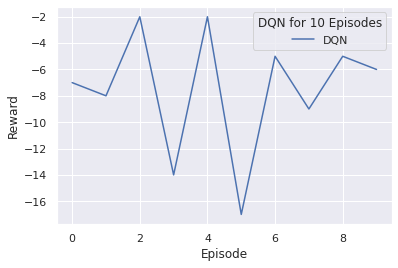

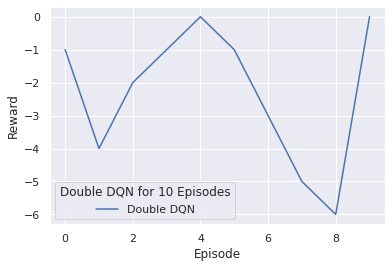

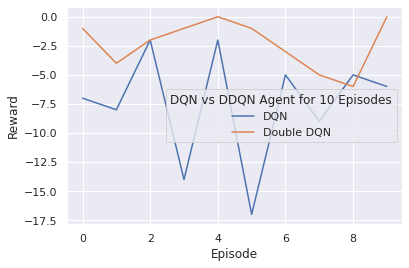


------------------------------------------------------------

Mean of rewards for 10 Episodes : -7.5 for Base DQN
Mean of rewards for 10 Episodes : -2.3 for Double DQN

------------------------------------------------------------



In [ ]:
# for 10 episodes

env = gym.make("GFootball-11_vs_11_kaggle-simple115v2-v0")
obs = env.reset()

number_of_episodes = 10

dqn_reward_history = run_multiple_episodes(env, baseDQNagent , n_episodes=number_of_episodes, 
                                           n_steps=3000, training=True, pr=True)

double_dqn_reward_history = run_multiple_episodes(env, doubleDQNagent, n_episodes=number_of_episodes, 
                                           n_steps=3000, training=True, pr=True)



plt.plot(dqn_reward_history, label='DQN')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(title='DQN for 10 Episodes')
plt.show()

plt.plot(double_dqn_reward_history, label='Double DQN')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(title='Double DQN for 10 Episodes')
plt.show()


plt.plot(dqn_reward_history, label='DQN')
plt.plot(double_dqn_reward_history, label='Double DQN')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(title='DQN vs DDQN Agent for 10 Episodes')
plt.show()

print("\n------------------------------------------------------------\n")
print("Mean of rewards for {} Episodes : {} for Base DQN".format(number_of_episodes, mean(dqn_reward_history) ))
print("Mean of rewards for {} Episodes : {} for Double DQN".format(number_of_episodes, mean(double_dqn_reward_history) ))
print("\n------------------------------------------------------------\n")

Episode 0 finished after 3000 steps, total reward: -8.0
Episode 1 finished after 3000 steps, total reward: -6.0
Episode 2 finished after 3000 steps, total reward: -7.0
Episode 3 finished after 3000 steps, total reward: -11.0
Episode 4 finished after 3000 steps, total reward: -4.0
Episode 5 finished after 3000 steps, total reward: -9.0
Episode 6 finished after 3000 steps, total reward: -4.0
Episode 7 finished after 3000 steps, total reward: -6.0
Episode 8 finished after 3000 steps, total reward: -9.0
Episode 9 finished after 3000 steps, total reward: -10.0
Episode 10 finished after 3000 steps, total reward: -6.0
Episode 11 finished after 3000 steps, total reward: -7.0
Episode 12 finished after 3000 steps, total reward: -11.0
Episode 13 finished after 3000 steps, total reward: -8.0
Episode 14 finished after 3000 steps, total reward: -6.0
Episode 15 finished after 3000 steps, total reward: -5.0
Episode 16 finished after 3000 steps, total reward: -7.0
Episode 17 finished after 3000 steps, 

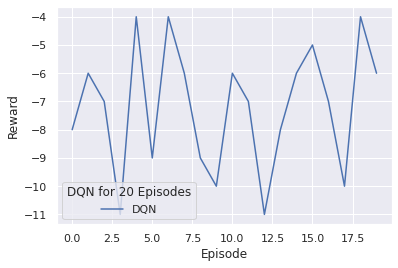

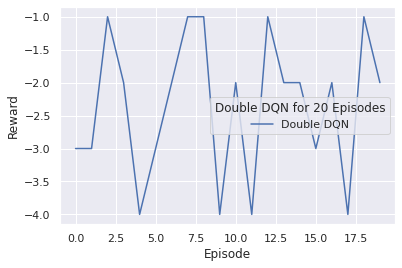

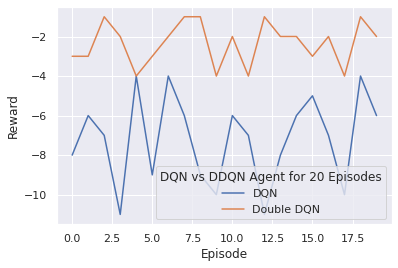


------------------------------------------------------------

Mean of rewards for 20 Episodes : -7.2 for Base DQN
Mean of rewards for 20 Episodes : -2.35 for Double DQN

------------------------------------------------------------



In [ ]:
# for 20 episodes

env = gym.make("GFootball-11_vs_11_kaggle-simple115v2-v0")
obs = env.reset()

number_of_episodes = 20

dqn_reward_history = run_multiple_episodes(env, doubleDQNagent, n_episodes=number_of_episodes, 
                                           n_steps=3000, training=True, pr=True)

double_dqn_reward_history = run_multiple_episodes(env, baseDQNagent, n_episodes=number_of_episodes, 
                                           n_steps=3000, training=True, pr=True)



plt.plot(dqn_reward_history, label='DQN')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(title='DQN for 20 Episodes')
plt.show()

plt.plot(double_dqn_reward_history, label='Double DQN')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(title='Double DQN for 20 Episodes')
plt.show()


plt.plot(dqn_reward_history, label='DQN')
plt.plot(double_dqn_reward_history, label='Double DQN')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(title='DQN vs DDQN Agent for 20 Episodes')
plt.show()

print("\n------------------------------------------------------------\n")
print("Mean of rewards for {} Episodes : {} for Base DQN".format(number_of_episodes, mean(dqn_reward_history) ))
print("Mean of rewards for {} Episodes : {} for Double DQN".format(number_of_episodes, mean(double_dqn_reward_history) ))
print("\n------------------------------------------------------------\n")

In [ ]:
!python --version

Python 3.7.10
